In [1]:
using Pkg
Pkg.activate("../")
Pkg.instantiate()
using CSV
using DataFrames
using Downloads
using Plots
using Dates
using RCall
@rimport base as R
untildate=Date("2022-10-15")
asdate(str::String, formats::AbstractVector{String})=R.as_Date.(Ref(str), formats).|>rcopy|>skipmissing|>first
asdate(str::Missing, format)=missing

  Activating project at `~/Library/CloudStorage/OneDrive-LondonSchoolofHygieneandTropicalMedicine/WorkDrive/2022monkeypox_depletion/monkeypox_depletion_of_susceptibles`


asdate (generic function with 2 methods)

In [2]:
# load data
if !isfile("../data/usmpx.csv") Downloads.download("https://raw.githubusercontent.com/akira-endo/us-mpx/main/output/mpx.csv","../data/usmpx.csv") end
usmpx_wf=CSV.read("../data/usmpx.csv",DataFrame)
usmpx_combined=DataFrame()
for date in Date("2022-6-1"):Day(1):untildate
    filename="../data/cdc_wayback/usmpx"*string(date)*".csv"
    if isfile(filename) # if wayback data exists use that data
        wbread=CSV.read(filename,DataFrame)
        if "Location" in names(wbread) rename!(wbread, :Location=>:State) end
        push!.(Ref(usmpx_combined), eachrow(DataFrame(State=wbread.State,Date=date,Cumulative_cases=wbread.Cases,Cases=0)))
    else # if wayback data not available use github data
        asdates=asdate.(usmpx_wf.AsOf, Ref(["Data as of %d %b %Y", "Data as of %b %d %Y"]))
        if date in skipmissing(asdates)
            datestamp=usmpx_wf.DateDT[findfirst(Base.Fix1(===,date),asdates)]
            wfread=usmpx_wf[usmpx_wf.DateDT.==datestamp,:]
            push!.(Ref(usmpx_combined), eachrow(DataFrame(State=wfread.StateDSC,Date=wfread.DateDT,Cumulative_cases=wfread.CasesCumulativeCNT,Cases=0)))
        end
    end
end
sort!(usmpx_combined)

,State,Date,Cumulative_cases,Cases
,String31,Date,Int64,Int64
1,Alabama,2022-07-15,2,0
2,Alabama,2022-07-18,2,0
3,Alabama,2022-07-19,2,0
4,Alabama,2022-07-21,6,0
5,Alabama,2022-07-22,4,0
6,Alabama,2022-07-25,5,0
7,Alabama,2022-07-26,5,0
8,Alabama,2022-07-27,6,0
9,Alabama,2022-07-28,17,0


In [3]:
function getdailycases!(df)
    for state in unique(df.State)
        df[df.State.==state,:Cases].=[0;df[df.State.==state,:Cumulative_cases]]|>diff
    end
    rename!(df,:State=>:Country)
end
getdailycases!(usmpx_combined)

,Country,Date,Cumulative_cases,Cases
,String31,Date,Int64,Int64
1,Alabama,2022-07-15,2,2
2,Alabama,2022-07-18,2,0
3,Alabama,2022-07-19,2,0
4,Alabama,2022-07-21,6,4
5,Alabama,2022-07-22,4,-2
6,Alabama,2022-07-25,5,1
7,Alabama,2022-07-26,5,0
8,Alabama,2022-07-27,6,1
9,Alabama,2022-07-28,17,11


In [4]:
CSV.write("../data/usmpx_combined.csv",usmpx_combined)

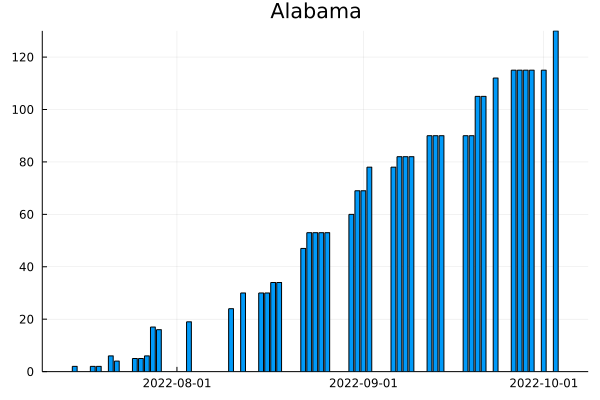

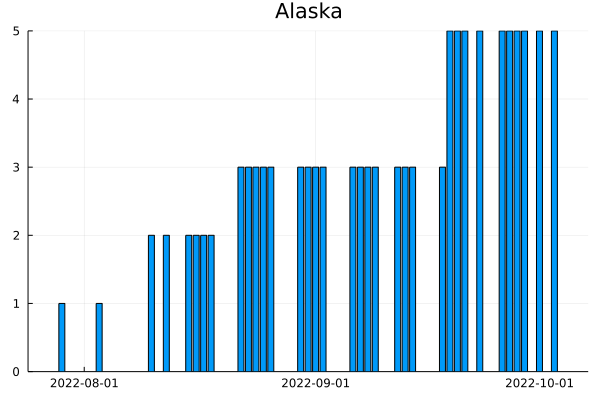

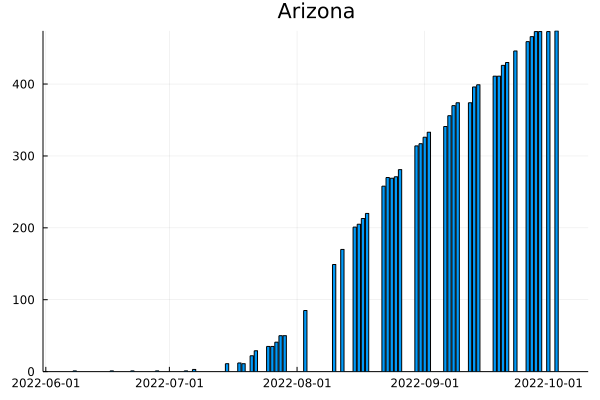

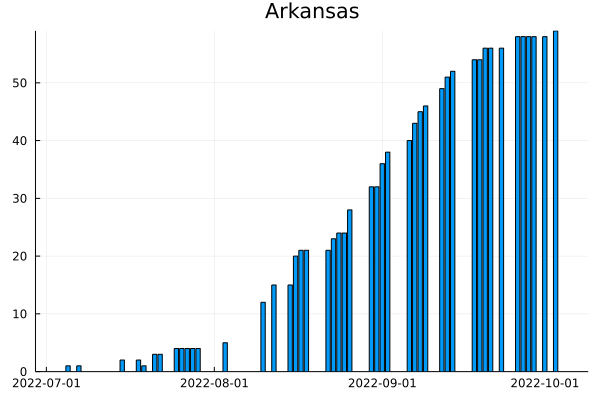

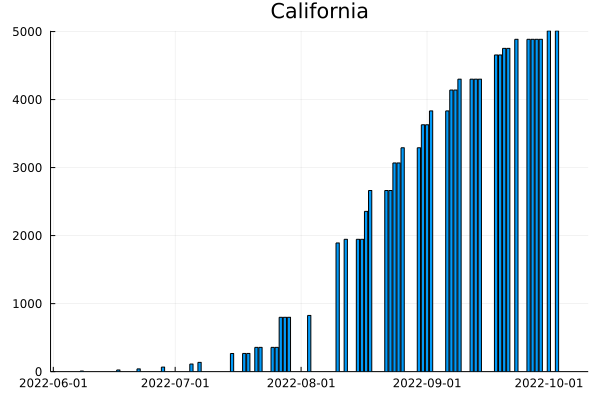

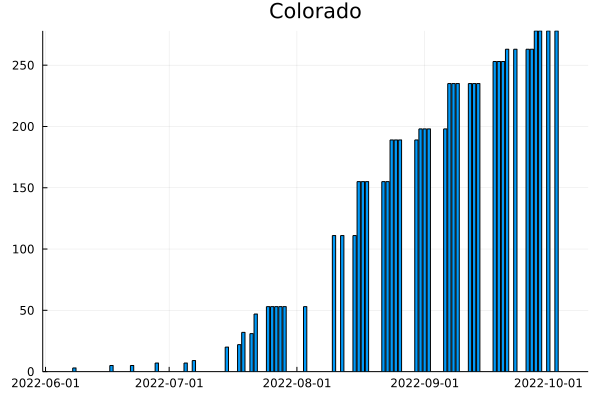

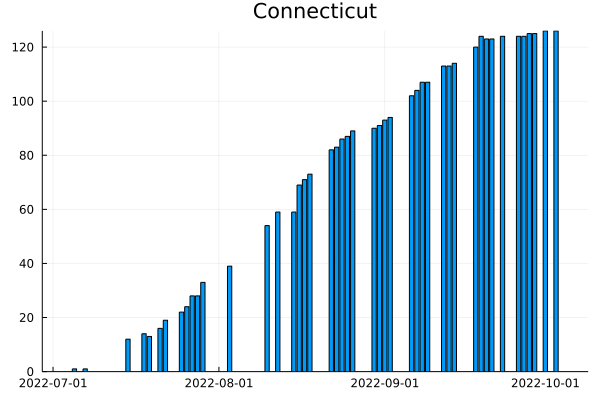

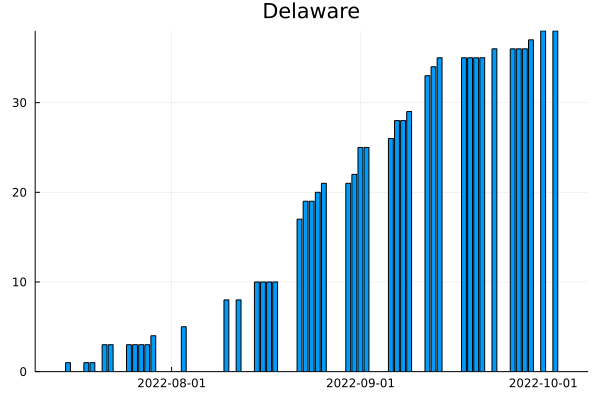

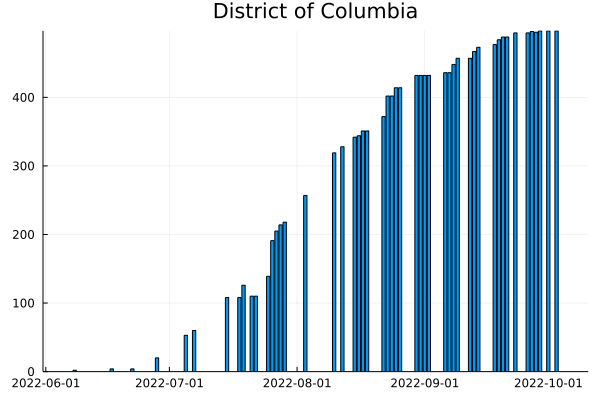

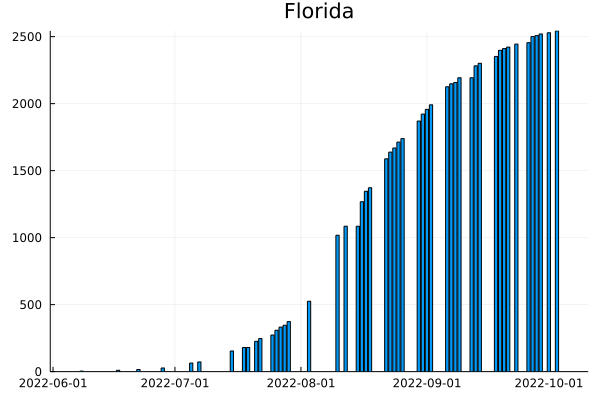

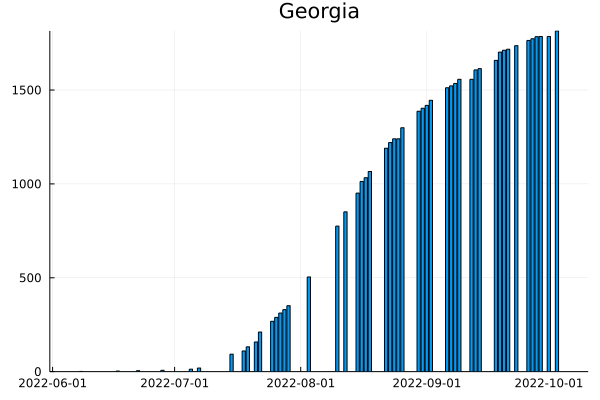

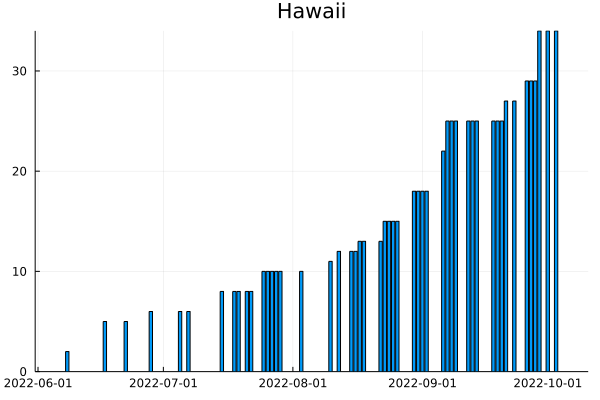

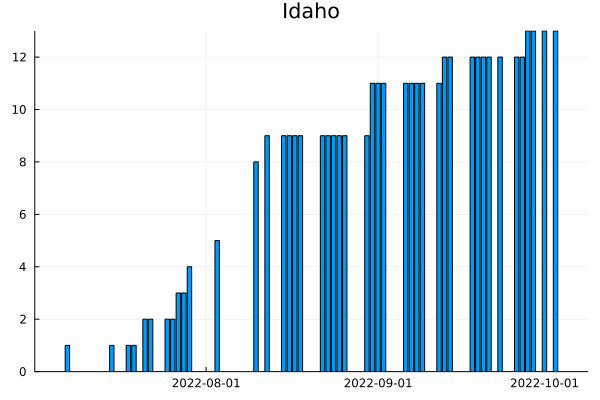

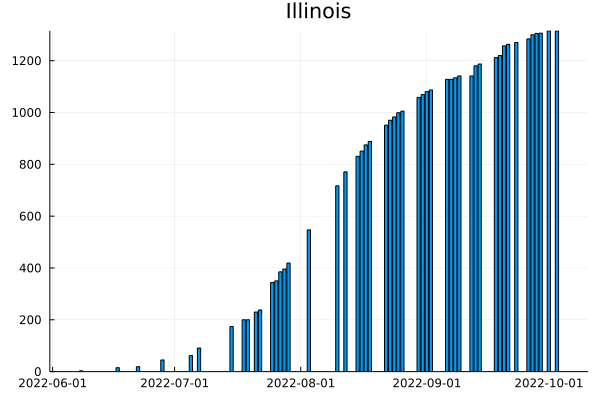

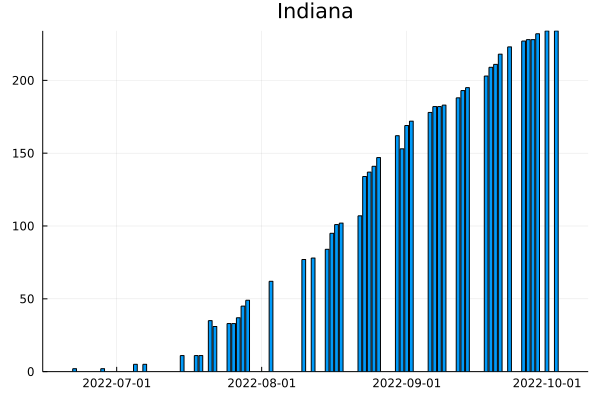

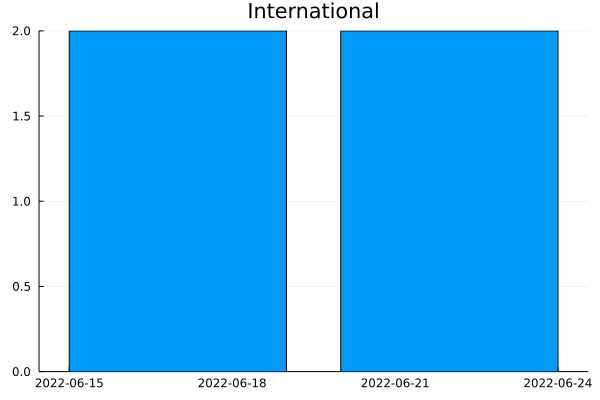

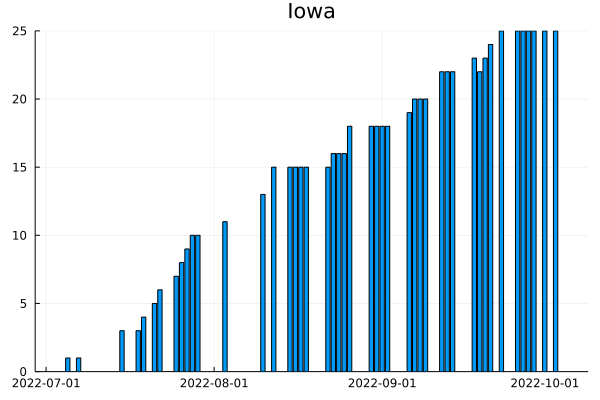

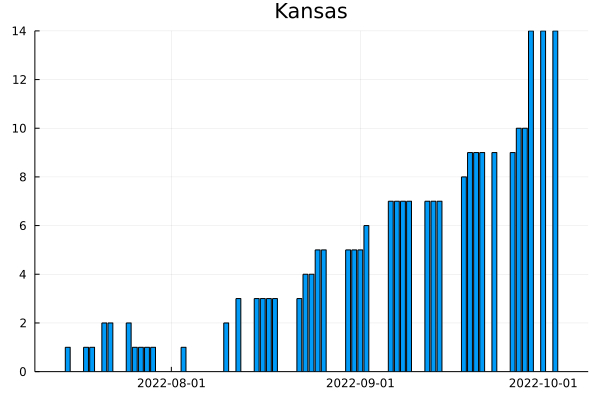

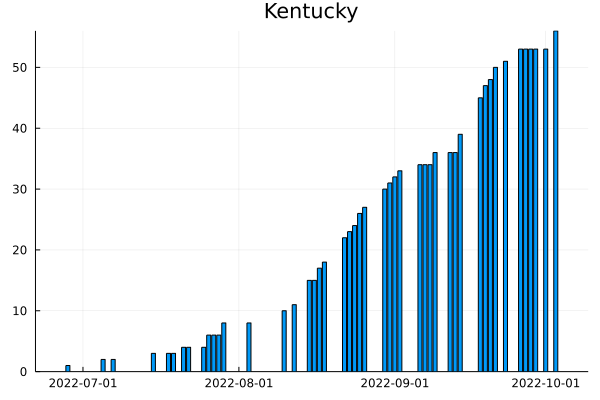

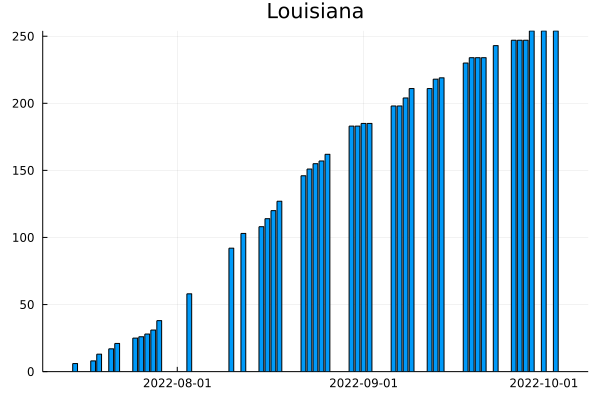

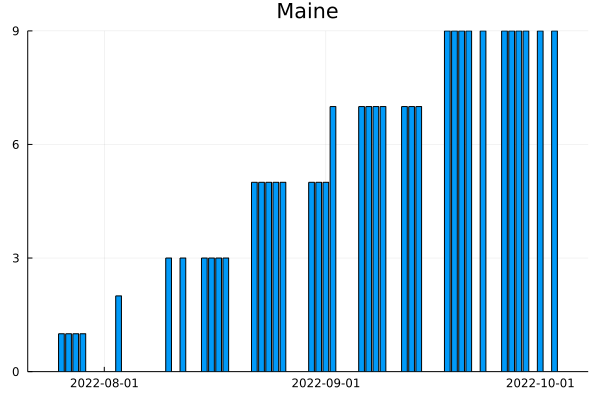

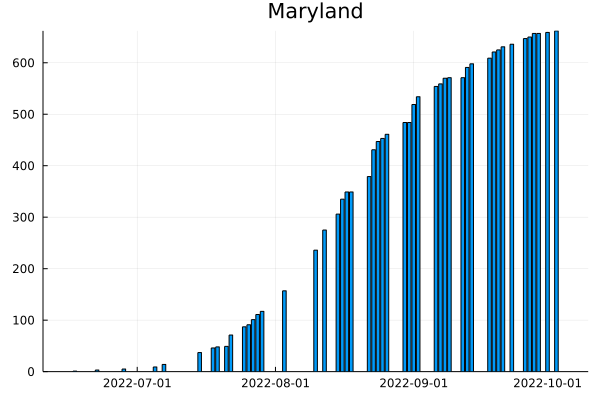

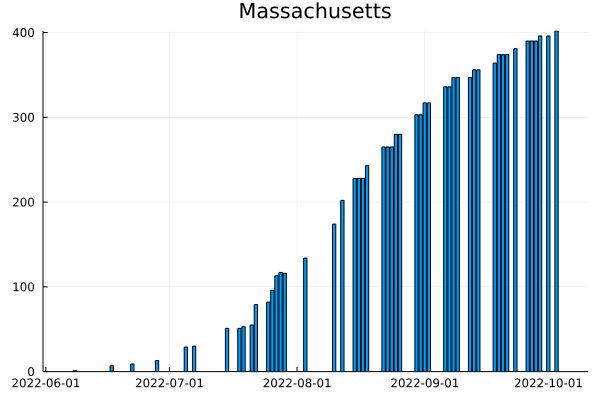

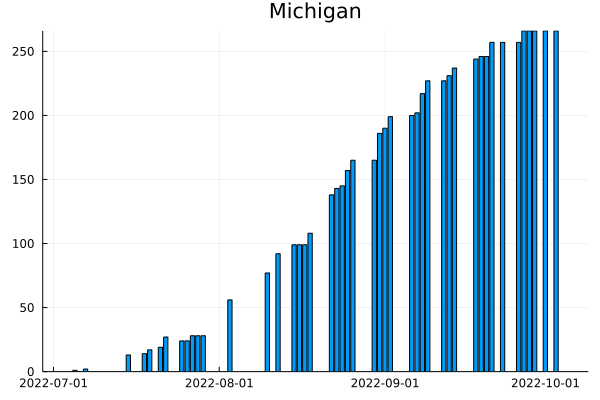

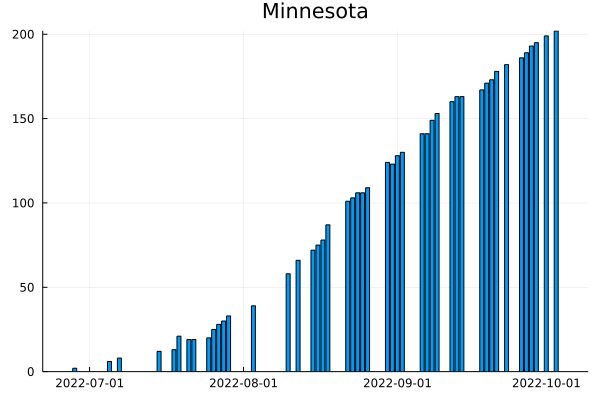

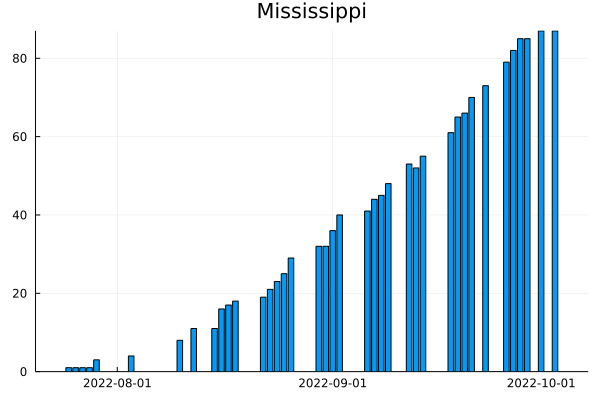

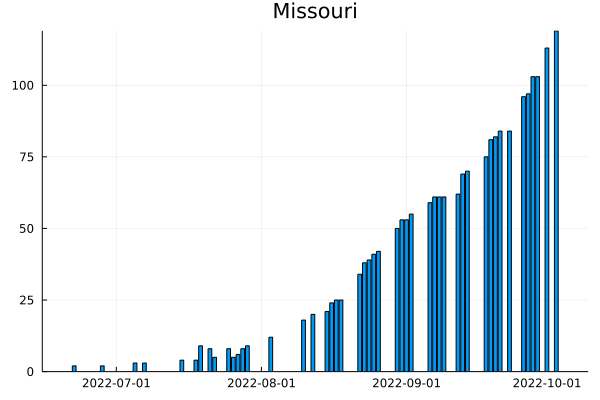

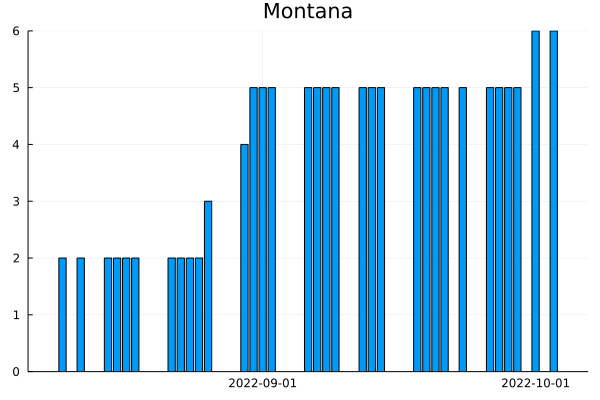

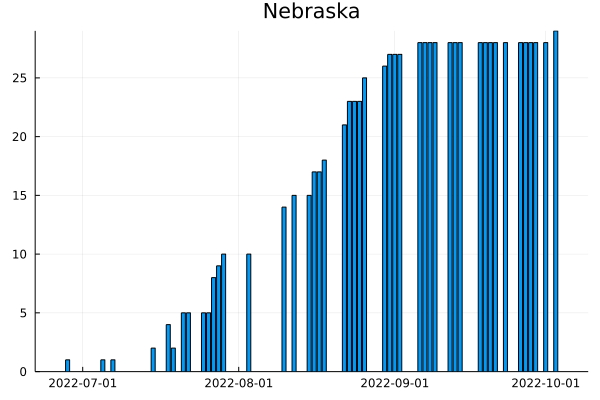

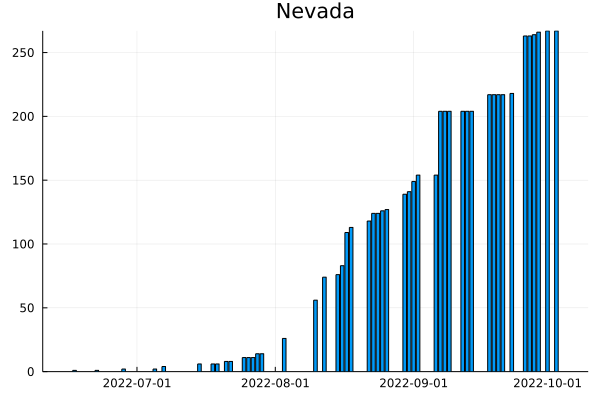

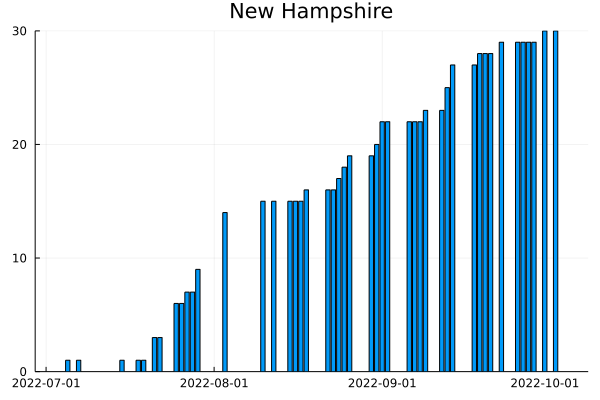

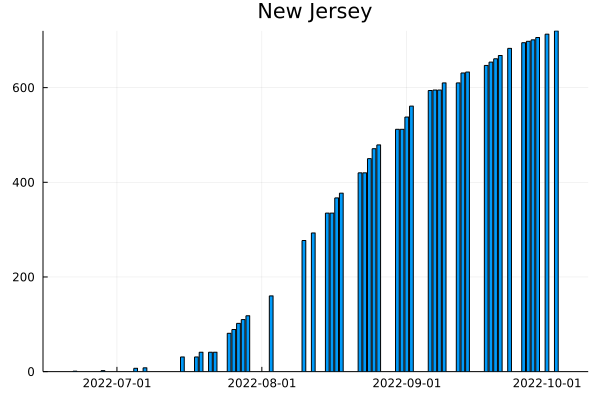

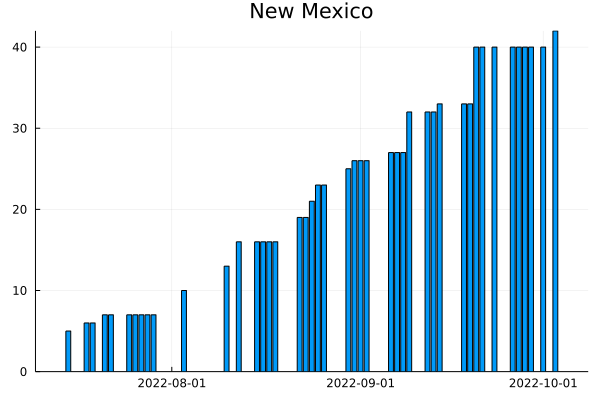

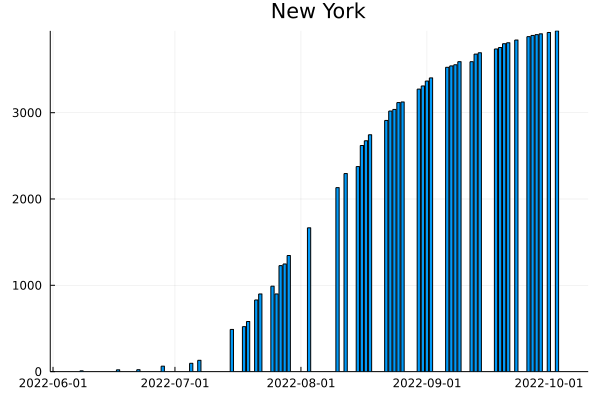

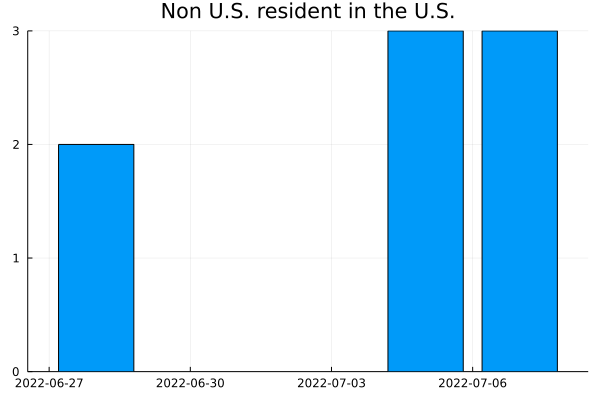

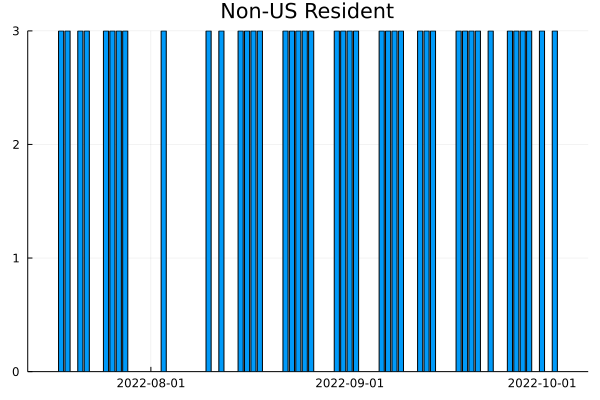

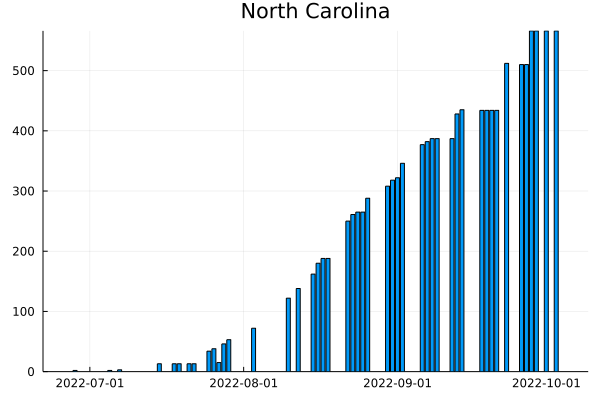

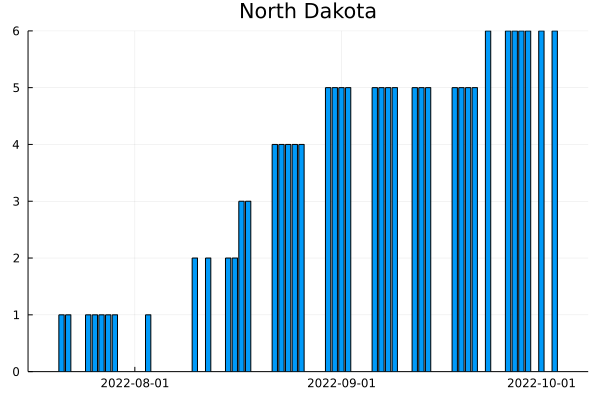

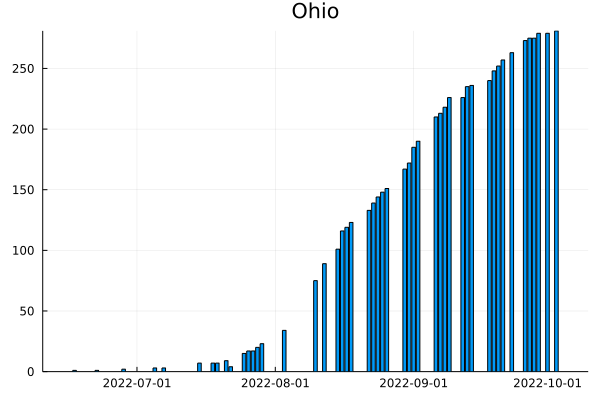

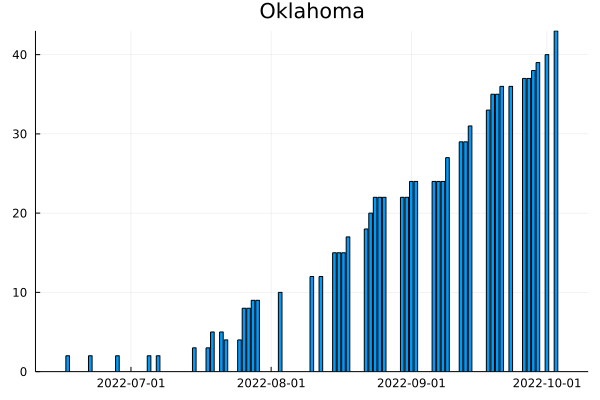

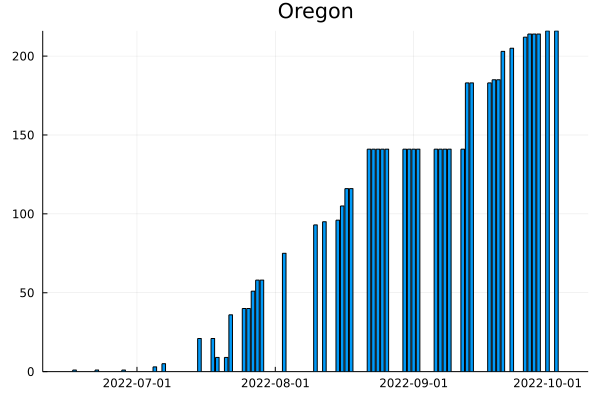

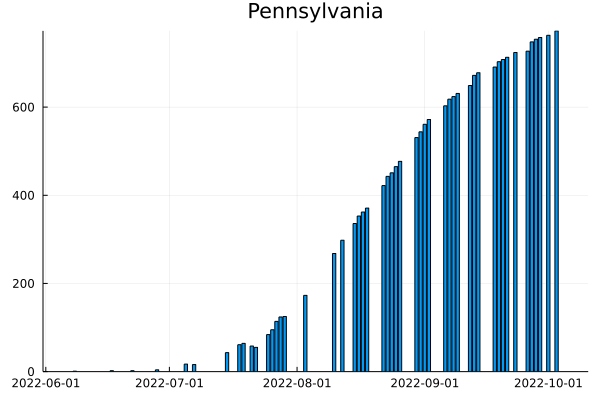

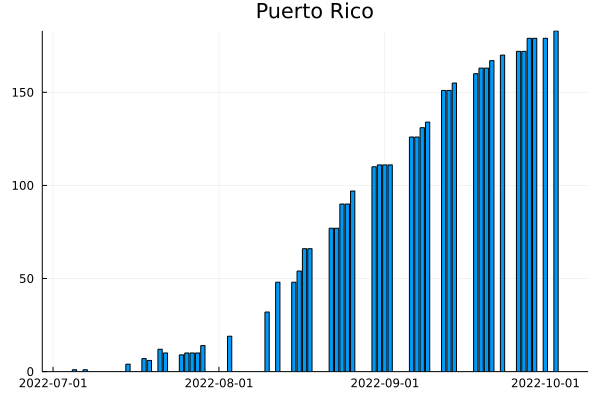

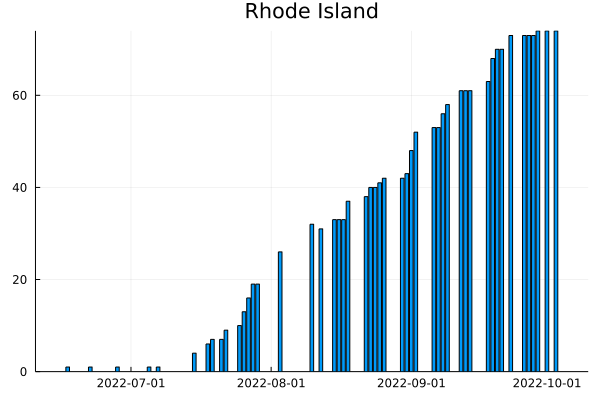

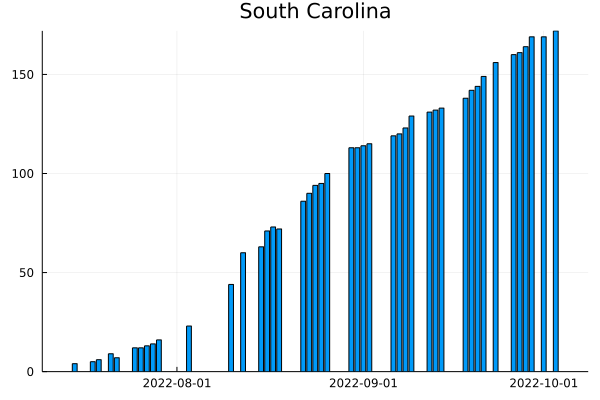

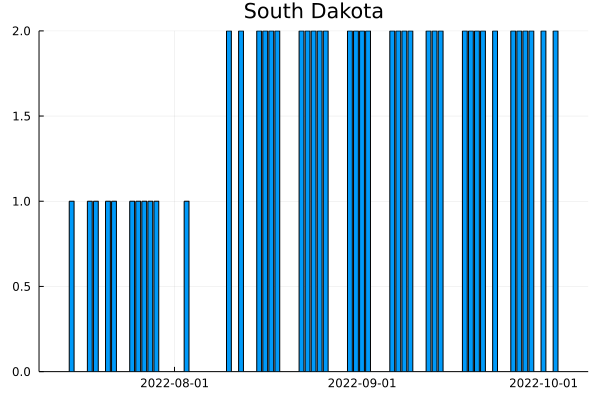

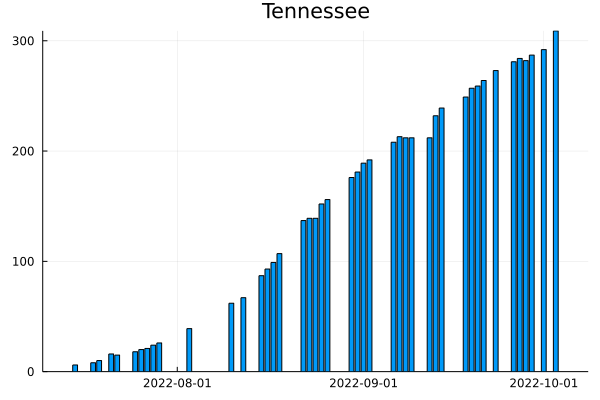

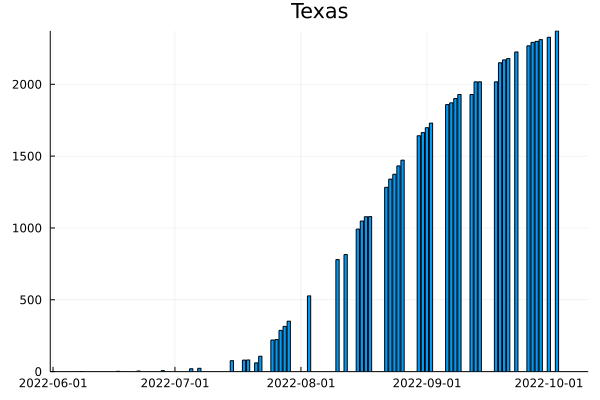

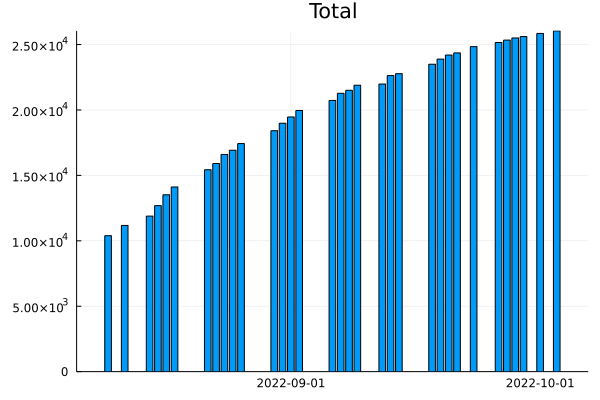

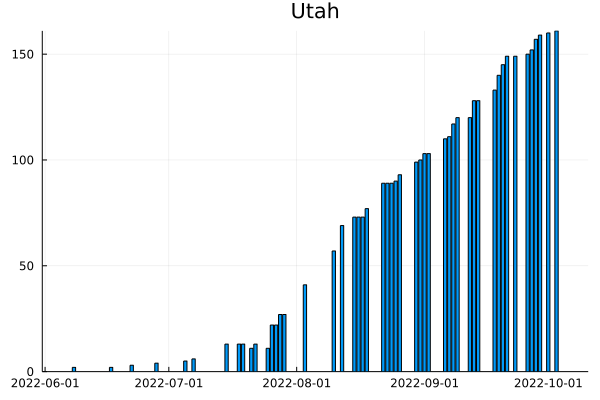

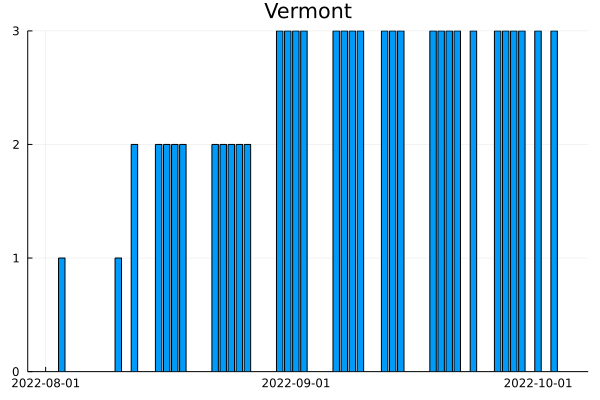

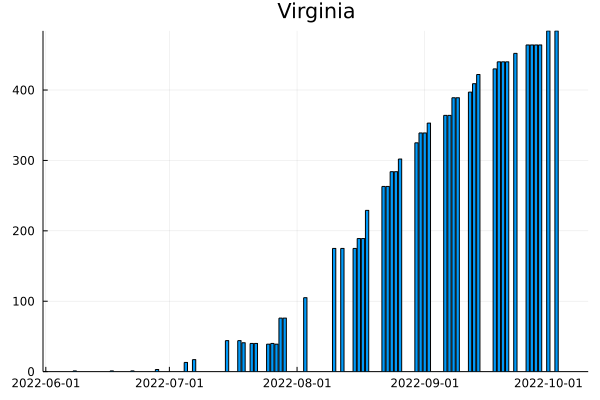

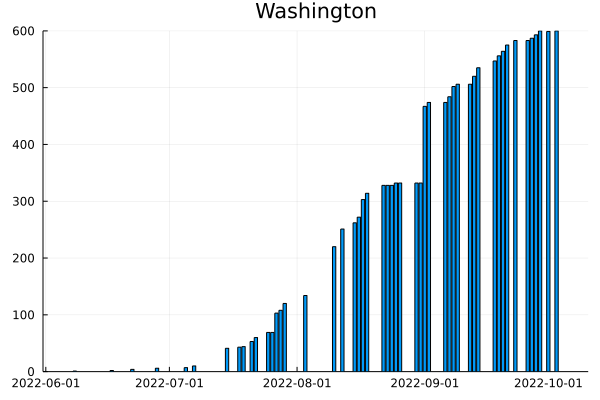

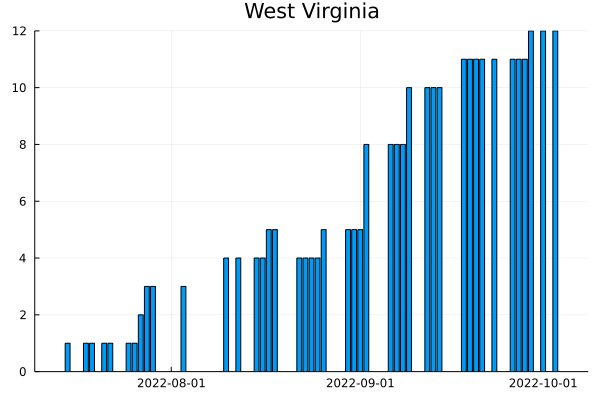

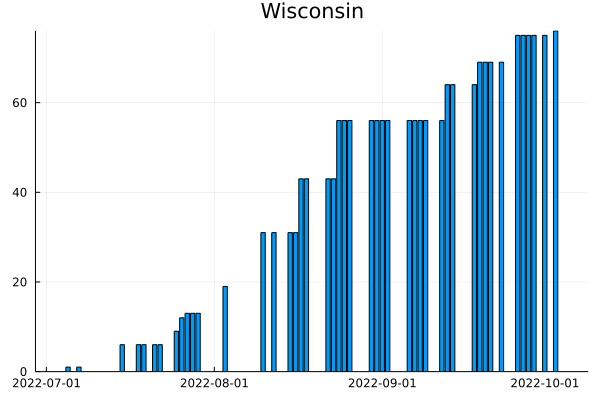

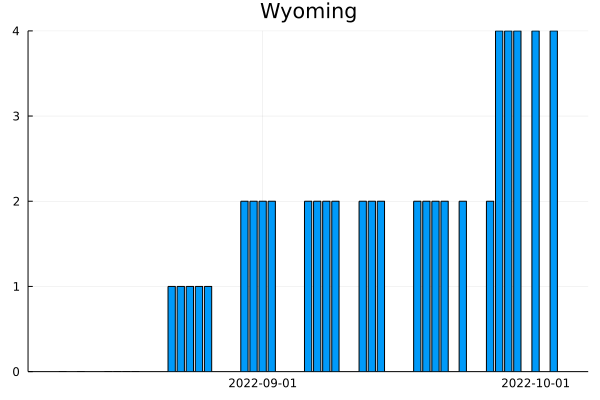

In [5]:
for state in unique(usmpx_combined.Country)
    bar(usmpx_combined[usmpx_combined.Country.==state,:Date],usmpx_combined[usmpx_combined.Country.==state,:Cumulative_cases],ylim=(0,usmpx_combined[usmpx_combined.Country.==state,:Cumulative_cases][end]),title=state,legend=:none)|>display
end